О наборе данных

Источник: симуляция рулетки

Описание

Этот набор данных содержит данные о 100 раундах рулетки. Он включает информацию о выпавших числах, цветах и результатах различных типов ставок.

Столбцы:
- Round – номер раунда
- Winning Number – выпавшее число (0-36)
- Winning Color – цвет числа (Red/Black/Green)
- Red Bet Win – выигрыш красной ставки (0/1)
- Black Bet Win – выигрыш черной ставки (0/1)
- Even Bet Win – выигрыш четной ставки (0/1)
- Odd Bet Win – выигрыш нечетной ставки (0/1)
- Zero Bet Win – выигрыш ставки на ноль (0/1)


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from itertools import combinations

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
df = pd.read_csv('roulette_100_rounds.csv')
df.describe()
df.head()


,Round,Winning Number,Winning Color,Red Bet Win,Black Bet Win,Even Bet Win,Odd Bet Win,Zero Bet Win
0,1,26,Black,0,1,1,0,0
1,2,24,Black,0,1,1,0,0
2,3,10,Black,0,1,1,0,0
3,4,31,Black,0,1,0,1,0
4,5,15,Black,0,1,0,1,0


Добавление нового атрибута

Новый атрибут - Roulette_Volatility, вычисляется как сумма отклонений от нормы атрибутов: Number_Dev, Distance_Dev, Frequency_Dev


In [29]:
def deviation(value, low, high):
    if value < low:
        return low - value
    elif value > high:
        return value - high
    else:
        return 0
df['Number_Frequency'] = df.groupby('Winning Number').cumcount() + 1
df['Distance_From_Previous'] = df['Winning Number'].diff().abs().fillna(0)
df['Rolling_Mean_Number'] = df['Winning Number'].rolling(window=5, min_periods=1).mean()

df['Number_Dev'] = df['Winning Number'].apply(lambda x: deviation(x, 0, 36))
df['Distance_Dev'] = df['Distance_From_Previous'].apply(lambda x: deviation(x, 0, 18))
df['Frequency_Dev'] = df['Number_Frequency'].apply(lambda x: deviation(x, 1, 3))
df['Roulette_Volatility'] = df['Number_Dev'] + df['Distance_Dev'] + df['Frequency_Dev']
df.head()


,Round,Winning Number,Winning Color,Red Bet Win,Black Bet Win,Even Bet Win,Odd Bet Win,Zero Bet Win,Number_Frequency,Distance_From_Previous,Rolling_Mean_Number,Number_Dev,Distance_Dev,Frequency_Dev,Roulette_Volatility
0,1,26,Black,0,1,1,0,0,1,0.0,26.00,0,0.0,0,0.0
1,2,24,Black,0,1,1,0,0,1,2.0,25.00,0,0.0,0,0.0
2,3,10,Black,0,1,1,0,0,1,14.0,20.00,0,0.0,0,0.0
3,4,31,Black,0,1,0,1,0,1,21.0,22.75,0,3.0,0,3.0
4,5,15,Black,0,1,0,1,0,1,16.0,21.20,0,0.0,0,0.0


Очистка данных

Удаление выбросов и дублей, обработка пропущенных значений

Примечание: Так как набор данных содержит данные симуляции рулетки, то критических выбросов быть не должно, но в рамках лабораторной работы я воспользуюсь методом IQR для нахождения выбросов, и заменю выбросы на граничные значения


In [30]:
print("Пропущенные значения в каждом столбце:")
print(df.isnull().sum())
print("\nОбщее количество пропущенных значений:", df.isnull().sum().sum())
duplicates = df.duplicated().sum()
print(f"\nНайдено дубликатов: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Удалено {duplicates} дубликатов")
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Столбец {column}: найдено {len(outliers)} выбросов")

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

numeric_columns = ['Winning Number', 'Distance_From_Previous', 'Number_Frequency',
                   'Rolling_Mean_Number', 'Roulette_Volatility']

for col in numeric_columns:
    df = handle_outliers_iqr(df, col)


Пропущенные значения в каждом столбце:
Round                     0
Winning Number            0
Winning Color             0
Red Bet Win               0
Black Bet Win             0
Even Bet Win              0
Odd Bet Win               0
Zero Bet Win              0
Number_Frequency          0
Distance_From_Previous    0
Rolling_Mean_Number       0
Number_Dev                0
Distance_Dev              0
Frequency_Dev             0
Roulette_Volatility       0
dtype: int64

Общее количество пропущенных значений: 0

Найдено дубликатов: 0
Столбец Winning Number: найдено 0 выбросов
Столбец Distance_From_Previous: найдено 0 выбросов
Столбец Number_Frequency: найдено 0 выбросов
Столбец Rolling_Mean_Number: найдено 2 выбросов
Столбец Roulette_Volatility: найдено 12 выбросов


Построение графиков зависимости


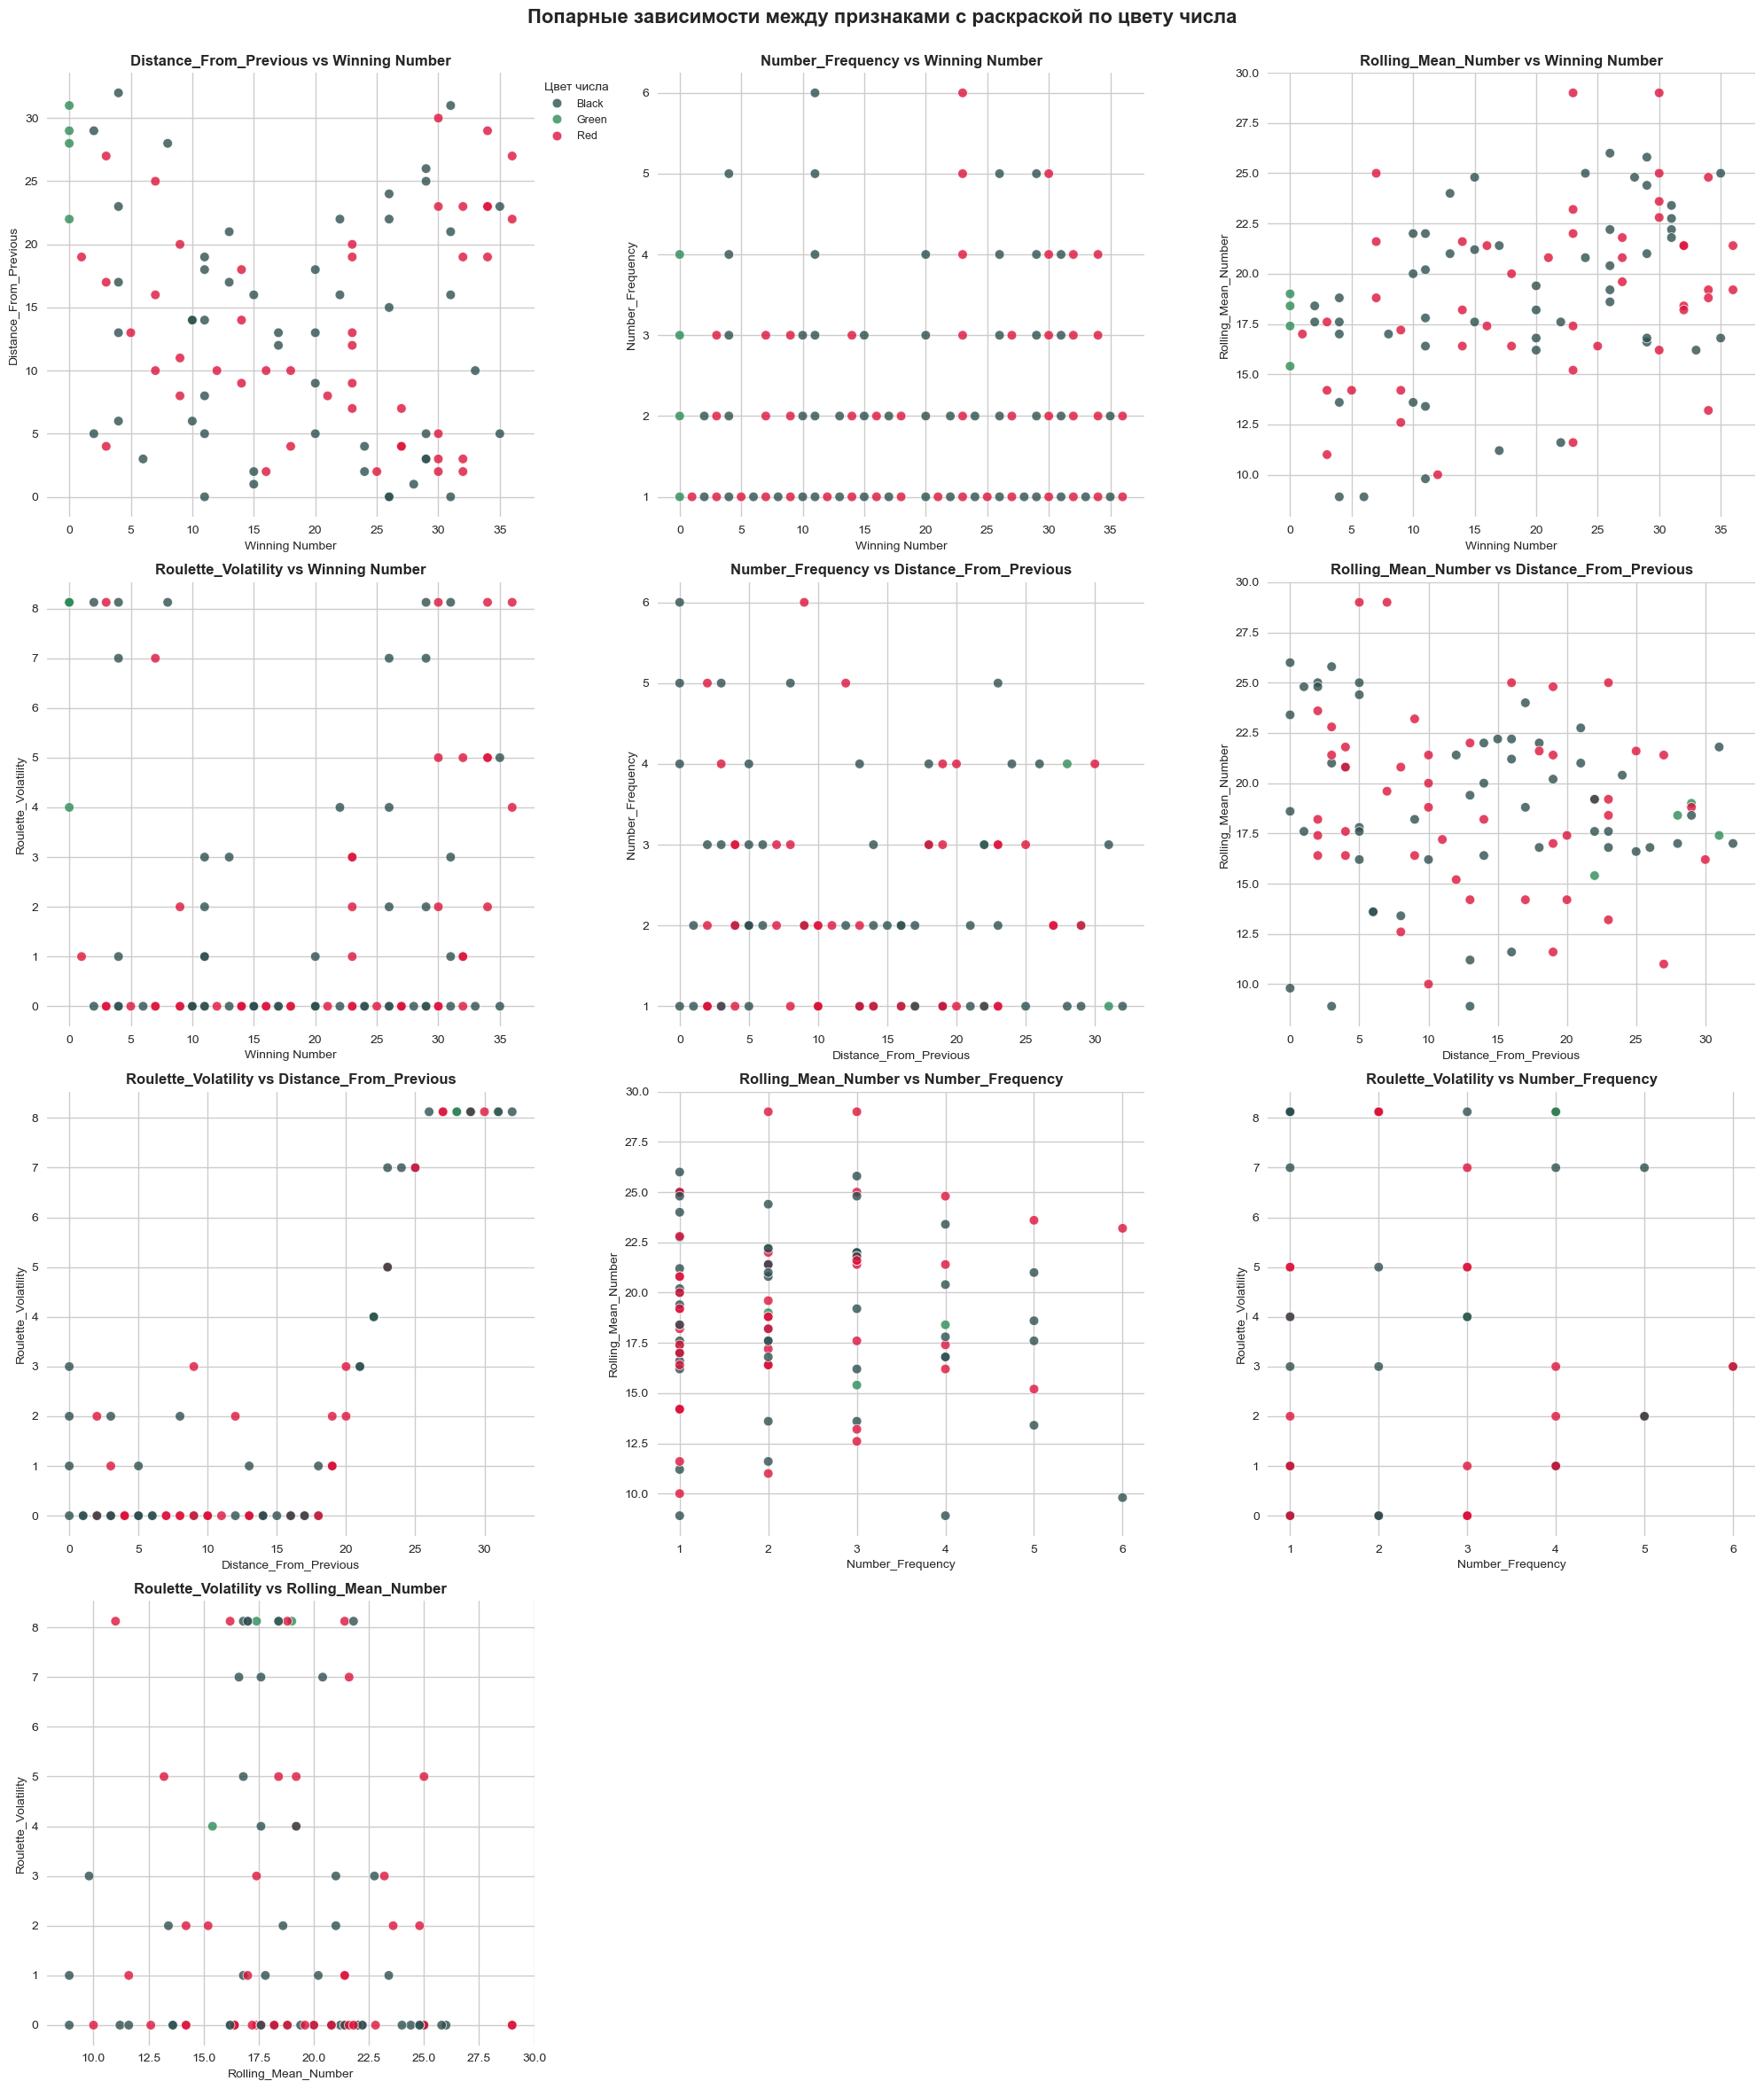

In [31]:
color_palette = {
    'Red': '#DC143C',
    'Black': '#2F4F4F',
    'Green': '#2E8B57'
}

plt.style.use('seaborn-v0_8')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
feature_pairs = list(combinations(numeric_columns, 2))

n = len(feature_pairs)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
fig.suptitle('Попарные зависимости между признаками с раскраской по цвету числа',
             fontsize=16, fontweight='bold', y=0.98)

axes = axes.flatten()

for i in range(n, len(axes)):
    fig.delaxes(axes[i])

for i, (x_feat, y_feat) in enumerate(feature_pairs):
    sns.scatterplot(data=df, x=x_feat, y=y_feat, hue='Winning Color',
                   palette=color_palette, alpha=0.8, s=60, ax=axes[i])
    axes[i].set_title(f'{y_feat} vs {x_feat}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(x_feat, fontsize=10)
    axes[i].set_ylabel(y_feat, fontsize=10)

    if i == 0:
        axes[i].legend(title='Цвет числа', title_fontsize=10, fontsize=9,
                      loc='upper left', bbox_to_anchor=(1, 1))
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


Анализ кластеров и групп в данных рулетки

На основе построенных scatter plots можно выделить следующие ярко выраженные кластеры и группы:

1. Выпавшее число vs Расстояние от предыдущего
- Кластер низких чисел: Winning Number 0-12, различные расстояния (преимущественно зеленые и черные точки)
- Кластер средних чисел: Winning Number 13-24, средние расстояния (красные и черные точки)
- Кластер высоких чисел: Winning Number 25-36, большие расстояния (красные точки)

2. Расстояние от предыдущего vs Частота повторений
- Группа уникальных чисел: Частота = 1, широкий разброс расстояний
- Группа повторяющихся чисел: Частота 2-4, меньшие расстояния
- Кластер "горячих" чисел: Высокая частота с малыми расстояниями

3. Скользящее среднее vs Выпавшее число
- Стабильная зона: Скользящее среднее ~18 (теоретическое среднее)
- Зона высоких чисел: Среднее >25, преобладание красных
- Зона низких чисел: Среднее <10, преобладание черных и зеленых

Наиболее выраженные группы:

1. Числа по цветам: Красные, Черные, Зеленые (0)
2. Числа по диапазонам: Первый десяток (1-12), Второй десяток (13-24), Третий десяток (25-36)
3. Числа по частоте: Уникальные (выпали 1 раз), Повторяющиеся (выпали 2+ раза)

Применение метода K-means для разбиения на кластеры

K-means работает только с числовыми данными, поэтому мы выбираем соответствующие признаки


In [32]:
X = df[numeric_columns].copy()


K-means чувствителен к масштабу данных, признаки с большим диапазоном значений могут доминировать в вычислении расстояний, поэтому необходимо масштабировать данные


In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Также надо определить оптимальное количество кластеров, для этого воспользуемся методом локтя (Elbow Method) и анализом силуэтного коэффициента (Silhouette Score)


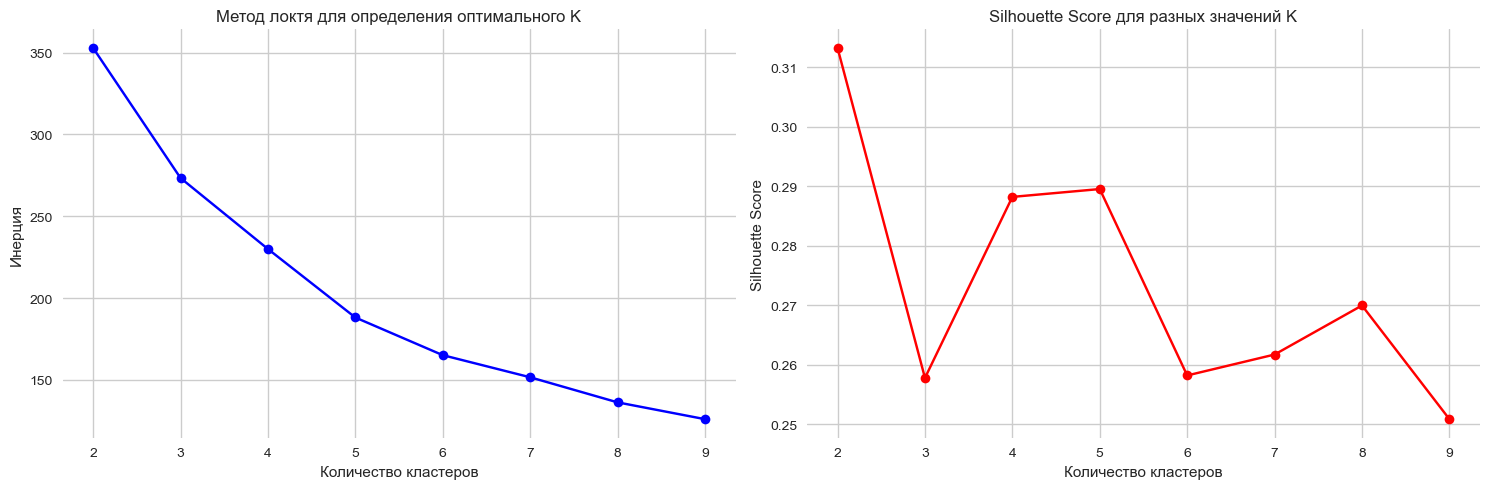

In [34]:
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Инерция')
ax1.set_title('Метод локтя для определения оптимального K')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для разных значений K')

plt.tight_layout()
plt.show()


Проанализировав графики, оптимальный k = 4
- На графике метода локтя нашел точку, где снижение инерции сильно замедляется
- На графике анализа силуэтного коэффициента высокий показатель при k = 4


Центры кластеров (оригинальные значения):
   Winning Number  Distance_From_Previous  Number_Frequency  \
0       27.555556                5.962963          2.629630   
1       30.470588               24.352941          2.352941   
2       12.760870               11.326087          2.086957   
3        2.800000               27.400000          2.300000   

   Rolling_Mean_Number  Roulette_Volatility  
0            23.051852             0.518519  
1            18.867647             5.742647  
2            16.808696             0.391304  
3            17.280000             7.487500  


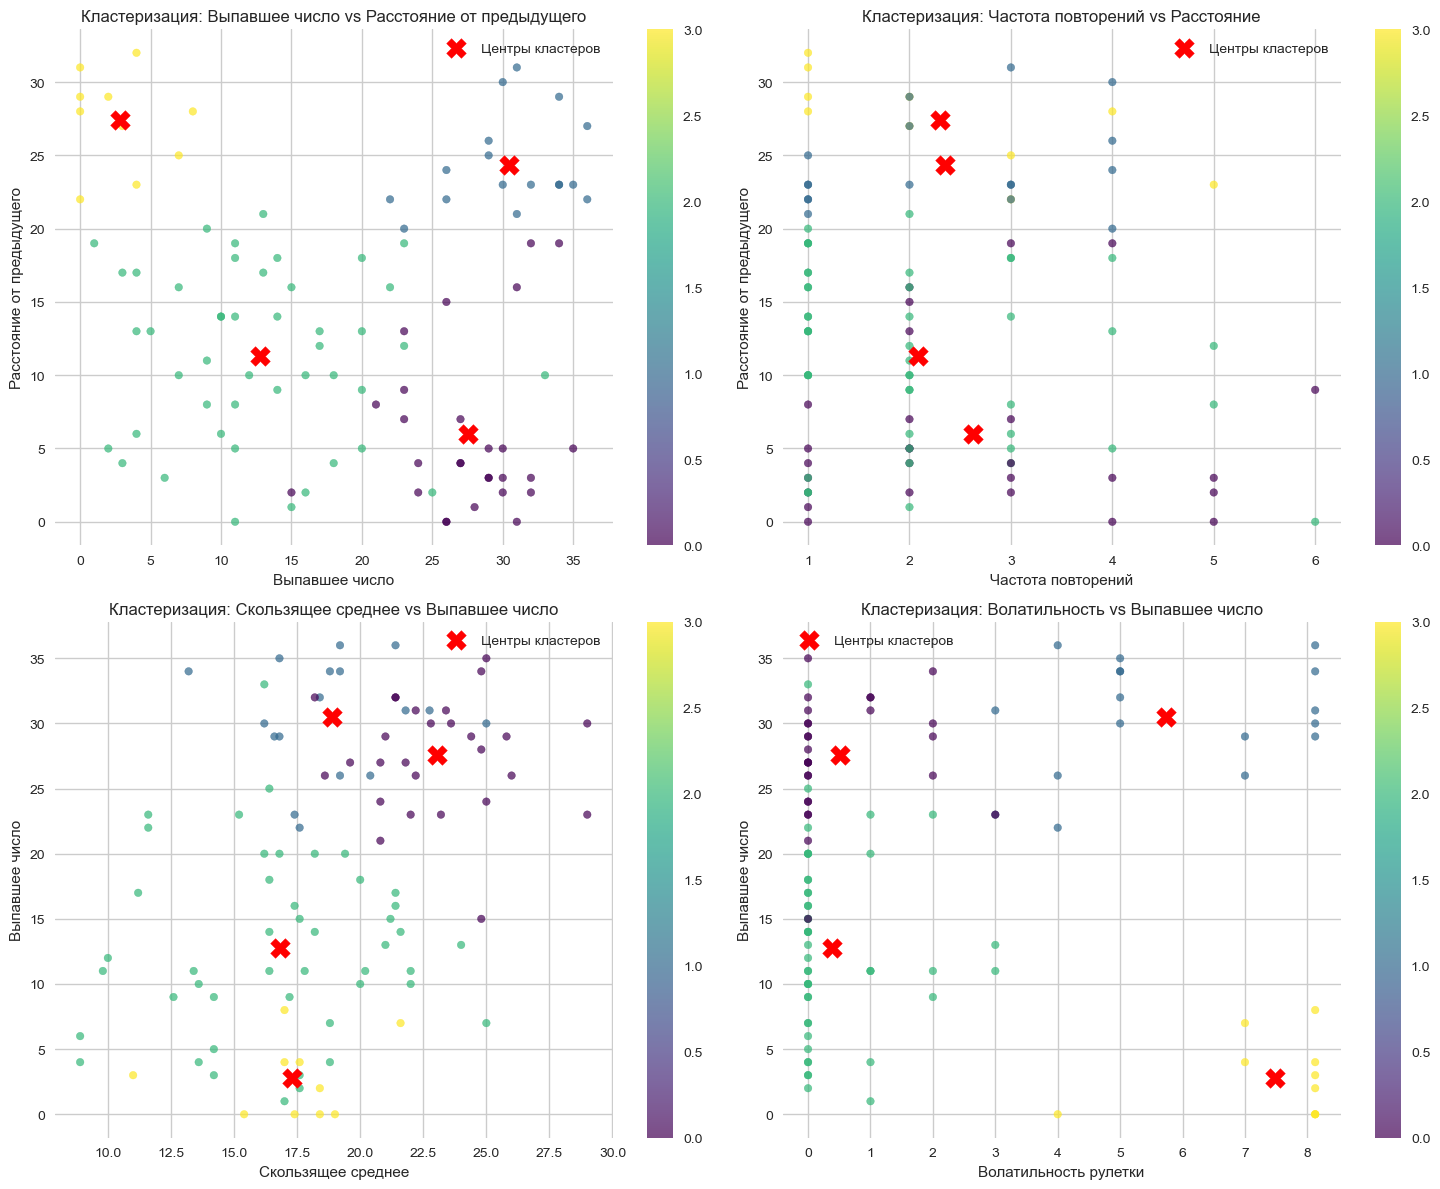

Средние значения признаков по кластерам:
         Winning Number  Distance_From_Previous  Number_Frequency  \
Cluster                                                             
0             27.555556                5.962963          2.629630   
1             30.470588               24.352941          2.352941   
2             12.760870               11.326087          2.086957   
3              2.800000               27.400000          2.300000   

         Rolling_Mean_Number  Roulette_Volatility  
Cluster                                            
0                  23.051852             0.518519  
1                  18.867647             5.742647  
2                  16.808696             0.391304  
3                  17.280000             7.487500  


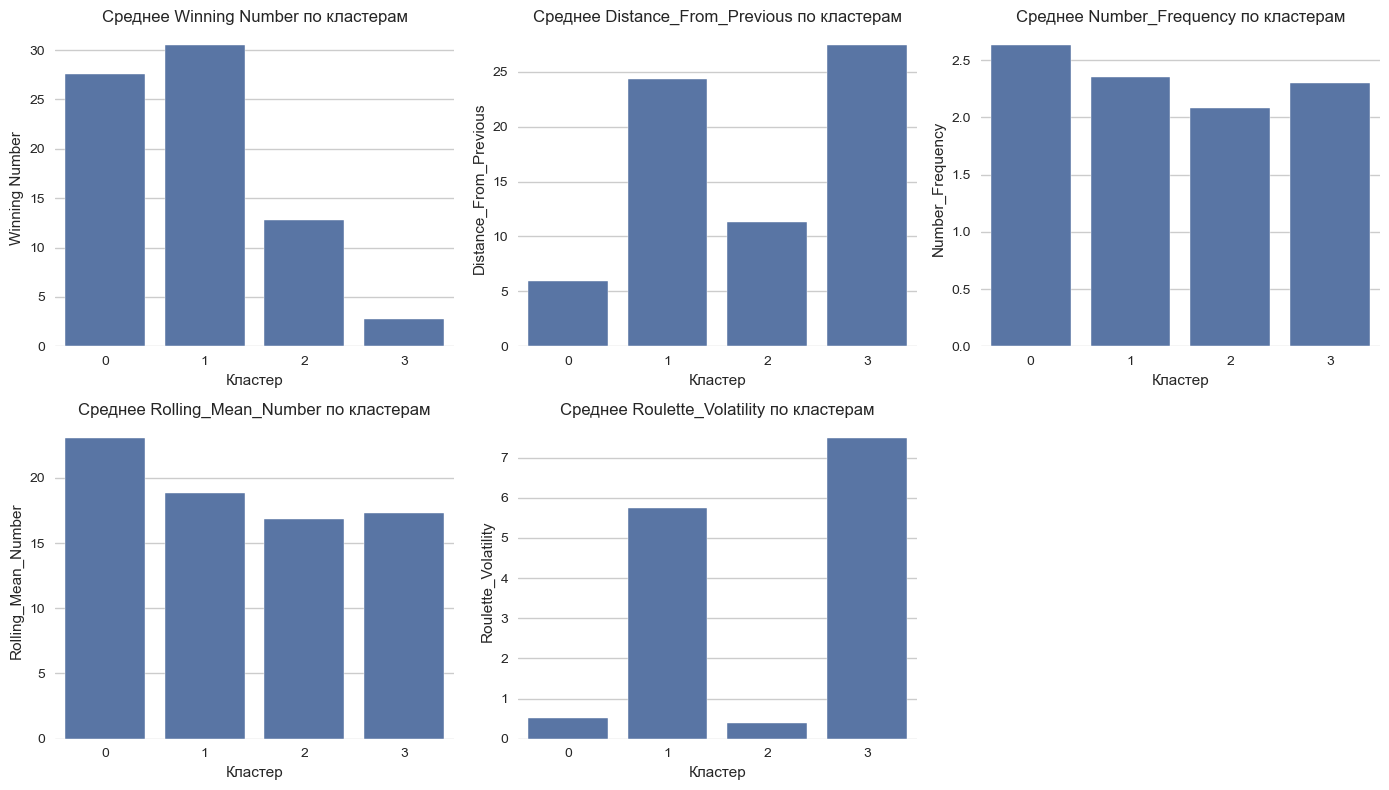

In [35]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numeric_columns)

print("Центры кластеров (оригинальные значения):")
print(cluster_centers_df)
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
scatter = plt.scatter(df['Winning Number'], df['Distance_From_Previous'],
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Winning Number'], cluster_centers_df['Distance_From_Previous'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Выпавшее число')
plt.ylabel('Расстояние от предыдущего')
plt.title('Кластеризация: Выпавшее число vs Расстояние от предыдущего')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 2)
scatter = plt.scatter(df['Number_Frequency'], df['Distance_From_Previous'],
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Number_Frequency'], cluster_centers_df['Distance_From_Previous'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Частота повторений')
plt.ylabel('Расстояние от предыдущего')
plt.title('Кластеризация: Частота повторений vs Расстояние')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 3)
scatter = plt.scatter(df['Rolling_Mean_Number'], df['Winning Number'],
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Rolling_Mean_Number'], cluster_centers_df['Winning Number'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Скользящее среднее')
plt.ylabel('Выпавшее число')
plt.title('Кластеризация: Скользящее среднее vs Выпавшее число')
plt.legend()
plt.colorbar(scatter)

plt.subplot(2, 2, 4)
scatter = plt.scatter(df['Roulette_Volatility'], df['Winning Number'],
                     c=df['Cluster'], cmap='viridis', alpha=0.7, s=30)
plt.scatter(cluster_centers_df['Roulette_Volatility'], cluster_centers_df['Winning Number'],
            c='red', marker='X', s=200, label='Центры кластеров')
plt.xlabel('Волатильность рулетки')
plt.ylabel('Выпавшее число')
plt.title('Кластеризация: Волатильность vs Выпавшее число')
plt.legend()
plt.colorbar(scatter)

plt.tight_layout()
plt.show()
cluster_stats = df.groupby('Cluster')[numeric_columns].mean()
print("Средние значения признаков по кластерам:")
print(cluster_stats)
plt.figure(figsize=(14, 8))
for i, feature in enumerate(numeric_columns):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=cluster_stats.index, y=cluster_stats[feature])
    plt.title(f'Среднее {feature} по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


Вывод

В ходе проделанной работы с датасетом рулетки были приобретены и применены важные навыки анализа данных: добавление нового информативного атрибута (волатильность рулетки, Roulette_Volatility) для расширения возможностей оценки изменчивости игрового процесса, тщательная предобработка данных — удаление дублей, выявление и обработка выбросов, а также визуальный анализ взаимосвязей между признаками с выявлением ярко выраженных групп и кластеров по цветам и диапазонам чисел. Изучение и применение на практике метода KMeans позволили разделить раунды рулетки на несколько однородных кластеров, отражающих различные паттерны игры.

Полученный анализ данных рулетки выявил чёткие группы раундов с различным уровнем волатильности и характеристиками выпадающих чисел. Введённый атрибут Roulette_Volatility помог понять влияние отклонений по выпавшему числу, расстоянию между числами и частоте повторений, что улучшило разделение игровых состояний. Кластеризация дала возможность выделить четыре основные подгруппы, каждая из которых характеризуется своим набором признаков и уровнем изменчивости.
